In [1]:
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from scipy.sparse.linalg import svds
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Getting data

In [2]:
dataset = fetch_20newsgroups(
    subset='all', 
    data_home='./sklearn_data', 
    remove=('headers', 'footers', 'quotes')
)
documents = dataset.data

In [3]:
documents_df = pd.DataFrame({'document': documents})
documents_df

,document
0,\n\nI am sure some bashers of Pens fans are pr...
1,My brother is in the market for a high-perform...
2,\n\n\n\n\tFinally you said what you dream abou...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...
4,1) I have an old Jasmine drive which I cann...
...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...
18842,\nNot in isolated ground recepticles (usually ...
18843,I just installed a DX2-66 CPU in a clone mothe...
18844,\nWouldn't this require a hyper-sphere. In 3-...


# Preprocessing data

In [4]:
def clean_documents(df, min_word_length=1):
    df['document_cleaned'] = pd.Series(df.document)
    df['document_cleaned'] = (
        df['document_cleaned']
        .pipe(lambda x: x.str.lower())  # make all letters lowercase 
        .pipe(lambda x: x.str.replace("\S*@\S*\s?", "", regex=True)) # remove email addresses
        .pipe(lambda x: x.str.replace("[^a-zA-Z#]", " ", regex=True)) # remove non-alphabetical characters
        .pipe(lambda x: pd.Series([' '.join([w for w in line if len(w) >= min_word_length]) for line in x.str.split()])) # get rid of short words
    )  

In [5]:
clean_documents(documents_df, min_word_length=3)
documents_df

,document,document_cleaned
0,\n\nI am sure some bashers of Pens fans are pr...,sure some bashers pens fans are pretty confuse...
1,My brother is in the market for a high-perform...,brother the market for high performance video ...
2,\n\n\n\n\tFinally you said what you dream abou...,finally you said what you dream about mediterr...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,think the scsi card doing the dma transfers no...
4,1) I have an old Jasmine drive which I cann...,have old jasmine drive which cannot use with n...
...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,from david nye neurology consultation cheaper ...
18842,\nNot in isolated ground recepticles (usually ...,not isolated ground recepticles usually unusua...
18843,I just installed a DX2-66 CPU in a clone mothe...,just installed cpu clone motherboard and tried...
18844,\nWouldn't this require a hyper-sphere. In 3-...,wouldn this require hyper sphere space points ...


# Create term-by-document matrix

In [6]:
tfidf = TfidfVectorizer(stop_words='english')
tdm = tfidf.fit_transform(documents_df.document_cleaned)
terms = tfidf.get_feature_names()
print(f'Found {tdm.shape[1]} terms in {tdm.shape[0]} documents.')
print("Example terms:", terms[:20])

Found 84337 terms in 18846 documents.
Example terms: ['aaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg', 'aaaaarrrrgh', 'aaaall', 'aaack', 'aaaggghhh', 'aaah', 'aaahh', 'aaahhhh', 'aaai', 'aaaread', 'aab', 'aacc', 'aachen', 'aacs', 'aaef', 'aaf', 'aagain']


# SVD

## sklearn.decomposition.TruncatedSVD

In [7]:
tsvd = TruncatedSVD(n_components=13, random_state=42)
tdm_tsvd = tsvd.fit_transform(tdm)

In [8]:
for i, components in enumerate(tsvd.components_):
    terms_components = zip(terms, components)
    sorted_terms = sorted(terms_components, key=lambda x:x[1], reverse=True)[:10]
    print(f"Topic {str(i + 1).zfill(2)}: {[term[0] for term in sorted_terms]}")

Topic 01: ['don', 'know', 'like', 'just', 'people', 'think', 'does', 'use', 'time', 'good']
Topic 02: ['windows', 'thanks', 'drive', 'card', 'dos', 'scsi', 'file', 'software', 'disk', 'mail']
Topic 03: ['god', 'windows', 'jesus', 'bible', 'does', 'dos', 'christ', 'thanks', 'faith', 'christian']
Topic 04: ['drive', 'scsi', 'ide', 'god', 'hard', 'drives', 'controller', 'disk', 'card', 'bus']
Topic 05: ['key', 'chip', 'government', 'encryption', 'clipper', 'keys', 'use', 'law', 'people', 'escrow']
Topic 06: ['thanks', 'mail', 'know', 'does', 'advance', 'email', 'info', 'looking', 'list', 'information']
Topic 07: ['key', 'god', 'game', 'chip', 'clipper', 'encryption', 'games', 'bit', 'keys', 'team']
Topic 08: ['card', 'video', 'monitor', 'mhz', 'bus', 'drivers', 'cards', 'vga', 'car', 'driver']
Topic 09: ['car', 'god', 'new', 'good', 'bike', 'window', 'space', 'engine', 'sale', 'just']
Topic 10: ['know', 'does', 'don', 'just', 'think', 'thanks', 'like', 'really', 'bike', 'say']
Topic 11: [

This is our **concept-by-term matrix**

In [9]:
tsvd.components_.shape

(13, 84337)

## scipy.sparse.linalg.svds

In [10]:
u, s, vt = svds(tdm, k=13)

In [11]:
display(u.shape)
display(s.shape)
display(vt.shape)

(18846, 13)

(13,)

(13, 84337)

In [12]:
d = np.matmul(s, vt)

In [13]:
tdm.shape

(18846, 84337)

## Optimal number of components

The optimal number of components is 13


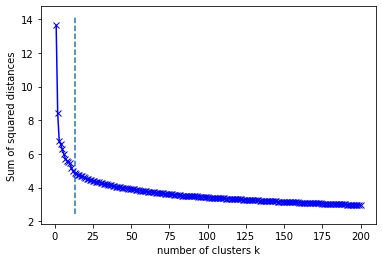

In [14]:
u, s, vt = svds(tdm, k=200)

import matplotlib.pyplot as plt
from kneed import KneeLocator

x = range(1, len(s)+1)
y = sorted(s, reverse=True)
kn = KneeLocator(x, y, curve='convex', direction='decreasing')
print(f"The optimal number of components is {kn.knee}")

plt.xlabel('number of clusters k')
plt.ylabel('Sum of squared distances')
plt.plot(x, y, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
